Distribución de género y sentimiento antes del preprocesamiento:
sentiment     0     1
gender               
female     1534    75
male         13  8378
Initial Model
Accuracy: 0.9056666666666666
Confusion Matrix:
 [[ 281  188]
 [  95 2436]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67       469
           1       0.93      0.96      0.95      2531

    accuracy                           0.91      3000
   macro avg       0.84      0.78      0.81      3000
weighted avg       0.90      0.91      0.90      3000

Metric Frame:
         accuracy  selection_rate  false_positive_rate  false_negative_rate
gender                                                                    
female  0.610526        0.412632             0.398268             0.076923
male    0.961188        0.961584             0.571429             0.037331


/Users/erika/repos/ipn/courses/ArtificialIntelligence2024/.venv-ai/lib/python3.10/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/Users/erika/

Mitigated Model
Accuracy after mitigation: 0.9056666666666666
Confusion Matrix after mitigation:
 [[ 281  188]
 [  95 2436]]
Classification Report after mitigation:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67       469
           1       0.93      0.96      0.95      2531

    accuracy                           0.91      3000
   macro avg       0.84      0.78      0.81      3000
weighted avg       0.90      0.91      0.90      3000

Metric Frame after mitigation:
         accuracy  selection_rate  false_positive_rate  false_negative_rate
gender                                                                    
female  0.610526        0.412632             0.398268             0.076923
male    0.961188        0.961584             0.571429             0.037331


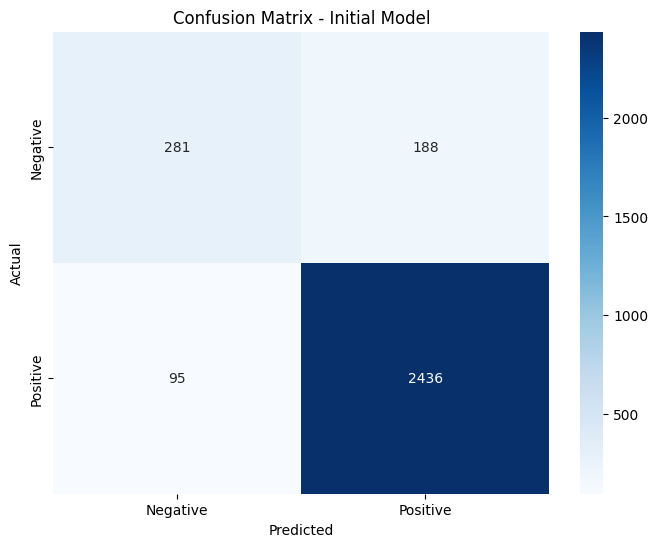

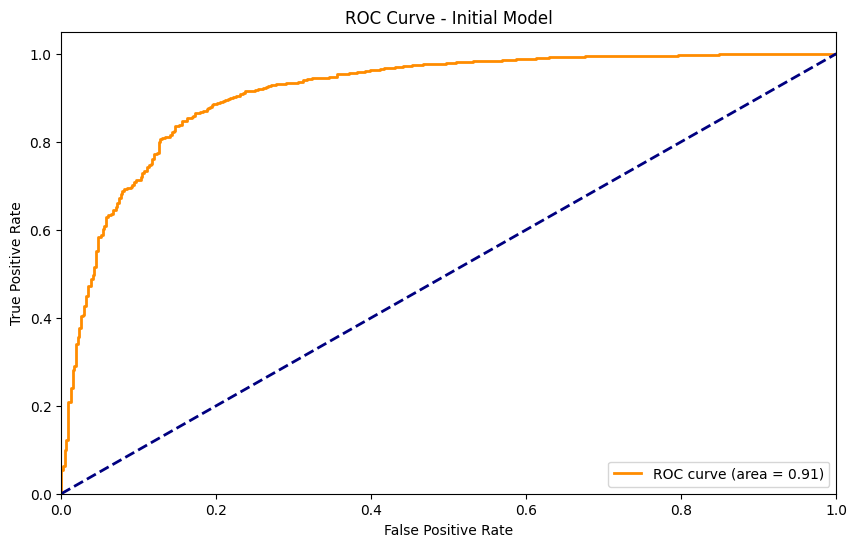

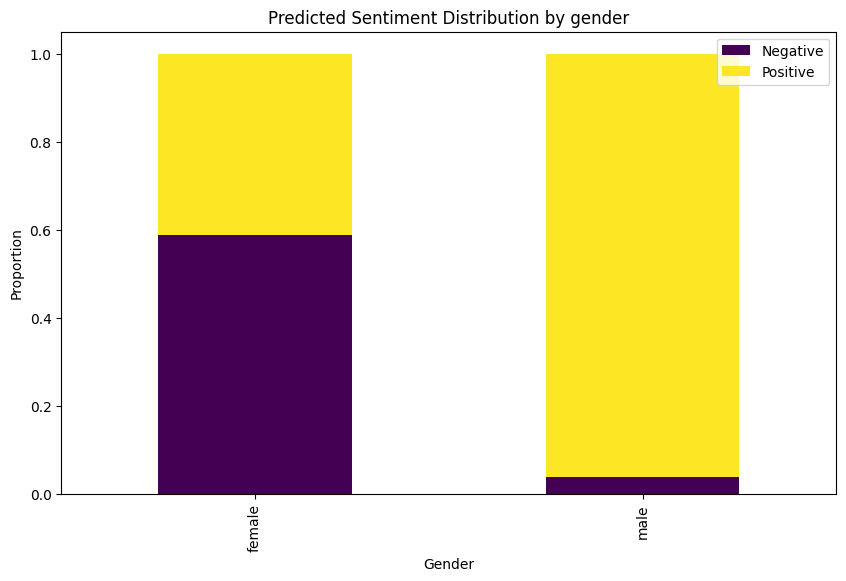

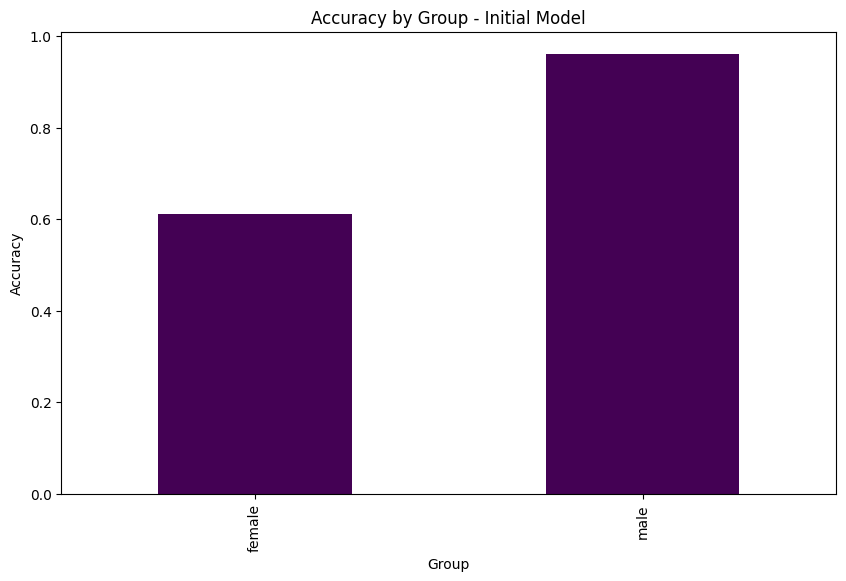

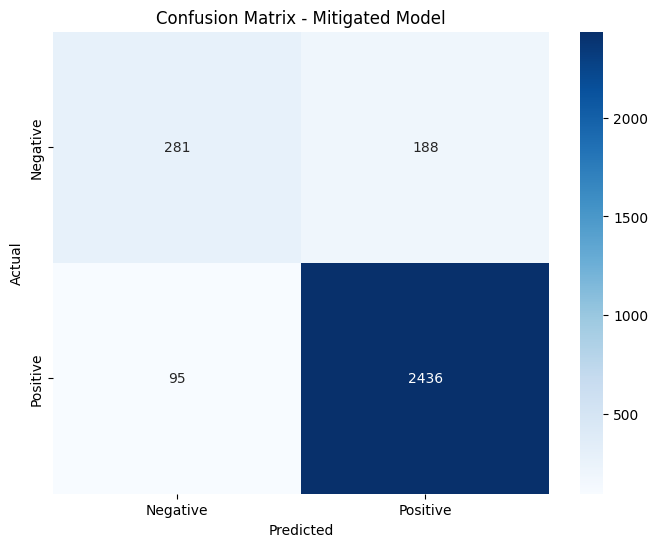

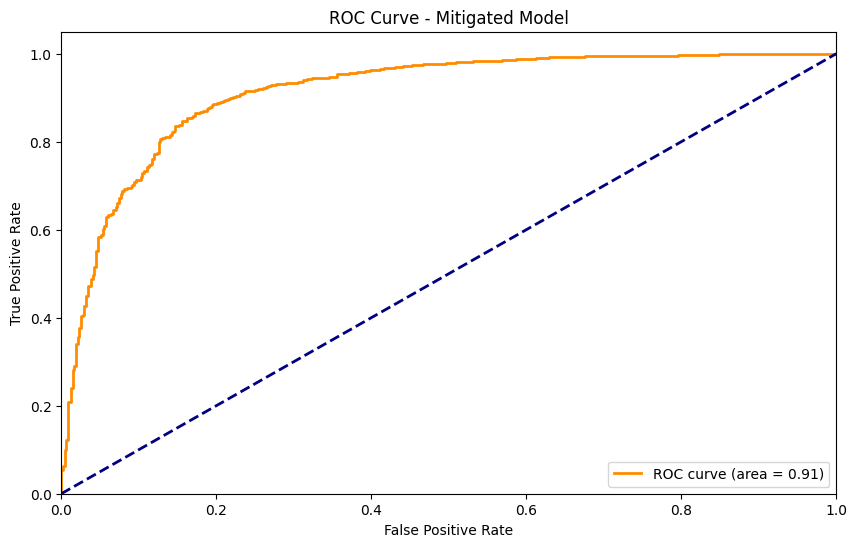

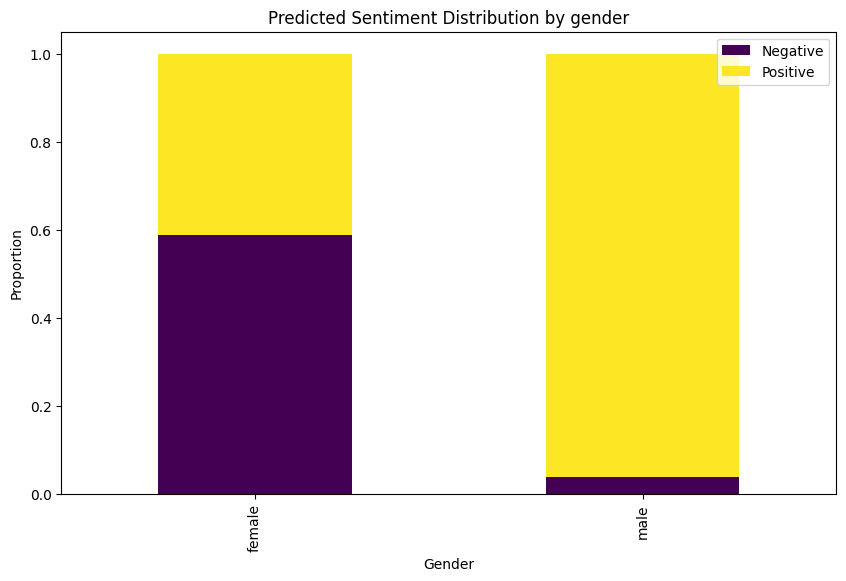

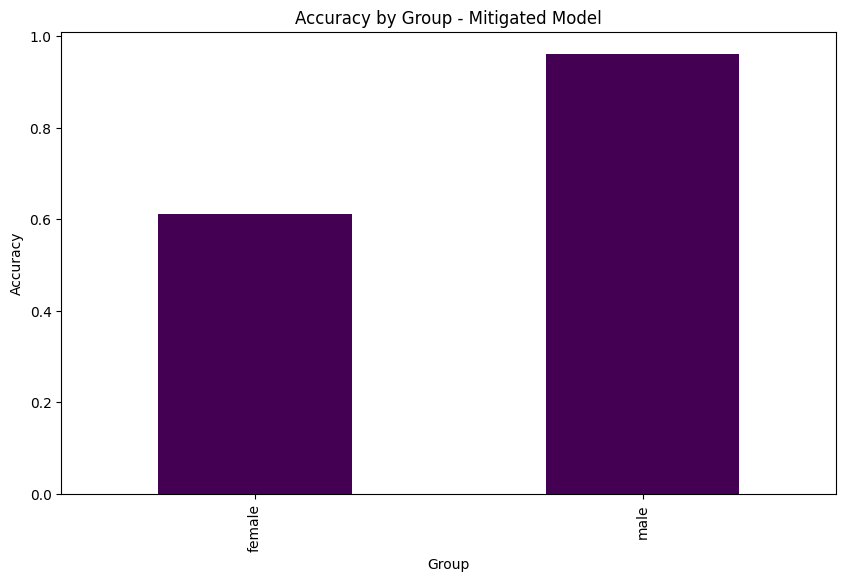

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, accuracy_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, false_negative_rate
from fairlearn.reductions import GridSearch, EqualizedOdds

# Cargar un subconjunto del dataset de Amazon Reviews
df = pd.read_csv('datos/Reviews.csv')

# Selección de un subconjunto y preprocesamiento de los datos
df = df[['Text', 'Score']].dropna()
df['sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0 if x < 3 else 2)  # 1 para positivo, 0 para negativo, 2 para neutro
df = df[df['sentiment'] != 2]  # Eliminamos la clase neutra
df = df.sample(10000, random_state=42)  # Subconjunto de 10,000 reseñas para rapidez en el ejemplo

# Crear la columna 'gender' con sesgo significativo
np.random.seed(42)
gender = []
for sentiment in df['sentiment']:
    if sentiment == 1:  # Positivo
        gender.append(np.random.choice(['male', 'female'], p=[0.99, 0.01]))  # 95% hombres en positivos
    else:  # Negativo
        gender.append(np.random.choice(['male', 'female'], p=[0.01, 0.99]))  # 95% mujeres en negativos
df['gender'] = gender

# Verificar la distribución inicial de género y sentimiento
print("Distribución de género y sentimiento antes del preprocesamiento:")
print(df.groupby(['gender', 'sentiment']).size().unstack().fillna(0))

# Preprocesamiento
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['Text']).toarray()  # Convertimos a matriz densa
y = df['sentiment']
sensitive_feature = df['gender']

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(X, y, sensitive_feature, test_size=0.3, random_state=42)

# Entrenamiento de un modelo básico
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluación inicial
print("Initial Model")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Evaluación del sesgo
metric_frame = MetricFrame(metrics={"accuracy": accuracy_score,
                                    "selection_rate": selection_rate,
                                    "false_positive_rate": false_positive_rate,
                                    "false_negative_rate": false_negative_rate},
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=sf_test)

print("Metric Frame:\n", metric_frame.by_group)

# Mitigación del sesgo
# Usamos GridSearch con Equalized Odds
constraint = EqualizedOdds()
mitigator = GridSearch(estimator=LogisticRegression(max_iter=1000), constraints=constraint, grid_size=10)
mitigator.fit(X_train, y_train, sensitive_features=sf_train)

y_pred_mitigated = mitigator.predict(X_test)

# Evaluación del modelo mitigado
print("Mitigated Model")
print("Accuracy after mitigation:", accuracy_score(y_test, y_pred_mitigated))
print("Confusion Matrix after mitigation:\n", confusion_matrix(y_test, y_pred_mitigated))
print("Classification Report after mitigation:\n", classification_report(y_test, y_pred_mitigated))

metric_frame_mitigated = MetricFrame(metrics={"accuracy": accuracy_score,
                                              "selection_rate": selection_rate,
                                              "false_positive_rate": false_positive_rate,
                                              "false_negative_rate": false_negative_rate},
                                     y_true=y_test,
                                     y_pred=y_pred_mitigated,
                                     sensitive_features=sf_test)

print("Metric Frame after mitigation:\n", metric_frame_mitigated.by_group)

# Matriz de Confusión
def plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Curva ROC y AUC
def plot_roc_curve(X_test, y_test, model, title="ROC Curve"):
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidad de la clase positiva
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Distribución de Predicciones por Grupo Sensible
def plot_predictions_by_group(y_test, y_pred, sf_test, group_name="gender"):
    results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, group_name: sf_test})
    group_counts = results.groupby([group_name, 'Predicted']).size().unstack().fillna(0)
    group_counts = group_counts.div(group_counts.sum(axis=1), axis=0)  # Normalizar
    group_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title(f'Predicted Sentiment Distribution by {group_name}')
    plt.xlabel(group_name.capitalize())
    plt.ylabel('Proportion')
    plt.legend(['Negative', 'Positive'], loc='upper right')
    plt.show()

# Metric Frame by Group
def plot_metric_frame(metric_frame, metric_name, title="Metric Frame by Group"):
    metric_frame.by_group[metric_name].plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title(title)
    plt.xlabel('Group')
    plt.ylabel(metric_name.capitalize())
    plt.show()

# Generación de las gráficas
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix - Initial Model")
plot_roc_curve(X_test, y_test, model, title="ROC Curve - Initial Model")
plot_predictions_by_group(y_test, y_pred, sf_test, group_name="gender")
plot_metric_frame(metric_frame, "accuracy", title="Accuracy by Group - Initial Model")

plot_confusion_matrix(y_test, y_pred_mitigated, title="Confusion Matrix - Mitigated Model")
plot_roc_curve(X_test, y_test, mitigator, title="ROC Curve - Mitigated Model")
plot_predictions_by_group(y_test, y_pred_mitigated, sf_test, group_name="gender")
plot_metric_frame(metric_frame_mitigated, "accuracy", title="Accuracy by Group - Mitigated Model")
